In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
path = tf.keras.utils.get_file('sunspots.csv', 
                               '  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv')
print (path)

73728/70827 [===============================] - 0s 0us/step
/root/.keras/datasets/sunspots.csv


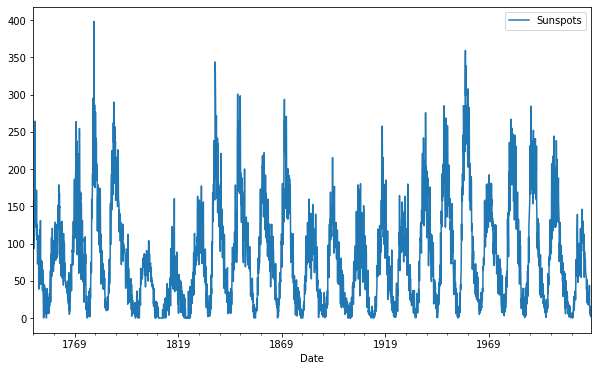

In [4]:
df = pd.read_csv(path, index_col='Date', parse_dates=True)
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.columns = ['Sunspots']   # reaname column
df.plot(figsize=(10,6))

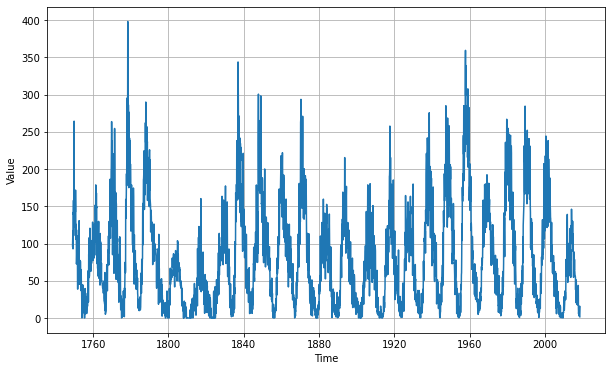

In [5]:
series = np.array(df['Sunspots'],float)
time = np.array(df.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [6]:
split_time = 3000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [7]:
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [8]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle = True)

In [9]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [11]:
window_size = 64
batch_size = 256
n_features = 1

In [12]:
# needed for lstm model.
x_train = x_train.reshape((len(x_train), n_features))

In [13]:
generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle=True)

In [14]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1950      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

In [17]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)

In [18]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [19]:
history = model.fit(generator, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
12/12 [==============================] - 9s 17ms/step - loss: 342.9075 - mae: 343.4075
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 320.0296 - mae: 320.5296
Epoch 3/100
12/12 [==============================] - 0s 11ms/step - loss: 288.2980 - mae: 288.7980
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 258.4037 - mae: 258.9037
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 230.3004 - mae: 230.8004
Epoch 6/100
12/12 [==============================] - 0s 10ms/step - loss: 193.9907 - mae: 194.4907
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 151.5925 - mae: 152.0925
Epoch 8/100
12/12 [==============================] - 0s 11ms/step - loss: 139.9360 - mae: 140.4360
Epoch 9/100
12/12 [==============================] - 0s 10ms/step - loss: 134.6720 - mae: 135.1720
Epoch 10/100
12/12 [==============================] - 0s 10ms/step - loss: 126.5367 - mae: 127.0367
Epoch 11/

(1e-08, 0.0001, 0.0, 60.0)

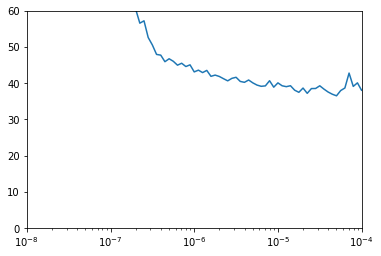

In [20]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [21]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [22]:
window_size = 64
batch_size = 256

In [23]:
generator = TimeseriesGenerator(x_train, x_train,
                                length = window_size, sampling_rate = 1, 
                                batch_size = batch_size, shuffle=True)

In [24]:
# needed for lstm model.
x_train = x_train.reshape((len(x_train), n_features))

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size = 5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [27]:
# using optimal lr from the first model's graph
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)

In [28]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [29]:
history = model.fit(generator,epochs=500)

Epoch 1/500
12/12 [==============================] - 3s 16ms/step - loss: 157.2632 - mae: 157.7625
Epoch 2/500
12/12 [==============================] - 0s 13ms/step - loss: 52.0677 - mae: 52.5654
Epoch 3/500
12/12 [==============================] - 0s 12ms/step - loss: 48.8474 - mae: 49.3454
Epoch 4/500
12/12 [==============================] - 0s 11ms/step - loss: 46.2052 - mae: 46.7030
Epoch 5/500
12/12 [==============================] - 0s 11ms/step - loss: 42.9884 - mae: 43.4858
Epoch 6/500
12/12 [==============================] - 0s 11ms/step - loss: 41.8048 - mae: 42.3022
Epoch 7/500
12/12 [==============================] - 0s 11ms/step - loss: 41.7281 - mae: 42.2254
Epoch 8/500
12/12 [==============================] - 0s 11ms/step - loss: 40.0370 - mae: 40.5343
Epoch 9/500
12/12 [==============================] - 0s 11ms/step - loss: 42.3307 - mae: 42.8277
Epoch 10/500
12/12 [==============================] - 0s 11ms/step - loss: 40.3641 - mae: 40.8611
Epoch 11/500
12/12 [=======

In [30]:
# We need to make it 2 dimimention - because RNN needs 3D
series_2d = np.array(df['Sunspots'],float)
print(series_2d.shape)
series_2d = series_2d.reshape((len(series_2d), n_features))
print(series_2d.shape)

(3235,)
(3235, 1)


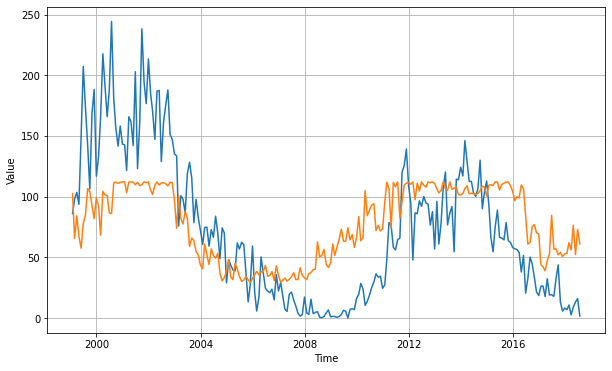

In [32]:
rnn_forecast=[]
for time in range(len(series_2d) - window_size):
  rnn_forecast.append(model.predict(series_2d[time : time + window_size][np.newaxis]))

rnn_forecast = rnn_forecast[split_time - window_size:]
rnn_forecast = np.array(rnn_forecast)[:, 0, 0]
rnn_forecast.shape

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [33]:
rnn_forecast_x = model_forecast(model, series_2d[..., np.newaxis], window_size)

In [34]:
rnn_forecast_x = rnn_forecast_x[split_time - window_size:-1, -1, 0]

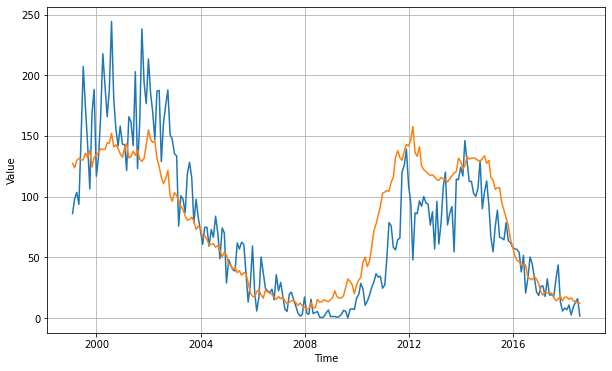

In [35]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast_x)

In [38]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast_x)

<tf.Tensor: shape=(), dtype=float32, numpy=23.26192>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
#print(rnn_forecast)